#Skin Lesions Classifications using CNN from scratch


### Initialization

In [ ]:
from google.colab import drive
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from tensorflow.keras import optimizers
from keras import layers
from keras import models
import math
import os
import shutil
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np

In [ ]:
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
TRAIN_DIR = '/content/gdrive/MyDrive/SkinCancer/BalancedDataset/train'
VAL_DIR = '/content/gdrive/MyDrive/SkinCancer/BalancedDataset/val'
TEST_DIR = '/content/gdrive/MyDrive/SkinCancer/BalancedDataset/test'
MODELS_PATH = '/content/gdrive/MyDrive/SkinCancer/Models'
LOCAL_MODELS_FOLDER = "/content/models"
if not os.path.exists(LOCAL_MODELS_FOLDER):
  os.makedirs(LOCAL_MODELS_FOLDER)
GLOBAL_MODELS_FOLDER = "/content/gdrive/MyDrive/SkinCancer/Models/CNN_from_scratch"
if not os.path.exists(GLOBAL_MODELS_FOLDER):
  os.makedirs(GLOBAL_MODELS_FOLDER)

CLASSES = ['Actinic', 'BCC', 'Dermatofibroma', 'Keratosis', 'Melanoma', 'Nevu', 'Vascular']
BATCH_SIZE = 32
RANDOM_SEED = 42
EPOCHS=50
DROPOUT = 0.3

Roba di test, poi toglila

In [ ]:
for i in range(0,7):
  path = '/content/gdrive/MyDrive/SkinCancer/BalancedDataset' + "/val/" + str(CLASSES[i])
  files = os.listdir(path)
  print(len(files))

49
78
17
164
166
1005
21


## Utility

In [ ]:
def compile_model(model, metrics='accuracy', loss='sparse_categorical_crossentropy', optimizer='adam', learning_rate = 0.001):
  '''
    compile_model is used to compile the current model
    :param model: model to compile
    :param optimizer: optimizer to be used
    :param learning_rate: learning rate parameter for the optimizer
  '''
  if optimizer == 'adam':
    optimizer=optimizers.Adam(learning_rate=learning_rate)
  elif optimizer == 'rmsprop':
    optimizer = optimizers.RMSprop(learning_rate=learning_rate)
  else:
    return

  model.compile(loss=loss,
    optimizer=optimizer,
    metrics=[metrics])

  return model

def run_model (model, model_name, train_ds, val_ds, epochs=50, patience=3, monitor='val_loss', class_weight=None):
  '''
  run_model is used to run the current mode
  :param model: model to run
  :param model_name: name given to save the model
  :param epochs: how many epochs to do
  :param patience: patience value for Early Stopping
  :param monitor: what to monitor for Early Stopping and Model Checkpoint
  '''
  # local save path for the models
  save_path = LOCAL_MODELS_FOLDER + '/' + model_name + ".h5"

  callbacks_list = [
                  keras.callbacks.EarlyStopping(monitor=monitor, patience=patience), #we implement EarlyStopping to prevent overfitting
                  keras.callbacks.ModelCheckpoint(
                      filepath = save_path,
                      monitor=monitor,
                      verbose=1,
                      save_best_only=True)
                  ]
           
  history = model.fit(train_ds,
                    epochs=epochs,
                    validation_data=val_ds,
                    callbacks=callbacks_list,
                    class_weight=class_weight
                    )
  # save on Drive only the best model
  shutil.copy(save_path, GLOBAL_MODELS_FOLDER + '/' + model_name + '.h5')
  return tf.keras.models.load_model(save_path), history


def show_training_and_validation_performance(history):
  '''
  show_training_and_validation_performance is used to plot the performances during the training phase
  :param history: object in which are recorded all the events
  '''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()


def evaluate_model(model, test_ds):
  test_loss, test_accuracy = model.evaluate(test_ds)
  print("Loss on test set: " +str(test_loss))
  print("Accuracy on test set: " +str(test_accuracy))
  test_labels = np.concatenate([label for image, label in test_ds], axis=0) # retrieve the labels of the test set
  test_predictions = model.predict(test_ds)  # probabilities for all classes
  test_predictions = np.argmax(test_predictions, axis=-1)  # index of the classes with largest probability
  print(metrics.classification_report(test_labels, test_predictions, target_names=CLASSES, digits=4))

def plot_confusionmatrix(model, test_ds):
  test_labels = np.concatenate([label for image, label in test_ds], axis=0) # retrieve the labels of the test set
  test_predictions = model.predict(test_ds, verbose=1)  # probabilities for all classes
  test_predictions = np.argmax(test_predictions, axis=-1)  # index of the classes with largest probability
  # plot confusion matrix
  fig, ax = plt.subplots(figsize=(10, 10))
  ConfusionMatrixDisplay.from_predictions(test_labels, test_predictions, xticks_rotation='vertical', ax=ax, display_labels=CLASSES)

# Approach: Balanced Dataset

##Dataset Loading

Note that since 450x600 is too large, It is used the interpolation tool in Keras to resize the images in 224x224, also to fit the input of most pretrained networks.

In [ ]:
training_images = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    labels='inferred',
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    image_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
    interpolation='bilinear',
    shuffle=True,
    seed=RANDOM_SEED
)

val_images = tf.keras.preprocessing.image_dataset_from_directory(
    VAL_DIR,
    labels='inferred',
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    image_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
    interpolation='bilinear',
    shuffle=True,
    seed=RANDOM_SEED
)

test_images = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR,
    labels='inferred',
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    image_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
    interpolation='bilinear',
    shuffle=False,
    seed=RANDOM_SEED
)

Found 2100 files belonging to 7 classes.
Found 1500 files belonging to 7 classes.
Found 1511 files belonging to 7 classes.


## Convolutional Layers = 3, Dense Layer = 1, Dropout Layer = 1

In [ ]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)
x = layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)
x = layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(DROPOUT)(x)
x = layers.Dense(256, activation='relu', name='hidden_classifier') (x)
outputs = layers.Dense(7, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model = compile_model(model, loss="sparse_categorical_crossentropy", optimizer = 'rmsprop', learning_rate=0.001)
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_4 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                       

In [ ]:
model, history = run_model(model, "Dense1_C3_Drop1_B", training_images, val_images, EPOCHS, patience=5, monitor='val_loss')

Epoch 1/50
66/66 [==============================] - ETA: 0s - loss: 4.2881 - accuracy: 0.2419
Epoch 1: val_loss improved from inf to 1.66582, saving model to /content/models/Dense1_C3_Drop1_B.h5
66/66 [==============================] - 20s 283ms/step - loss: 4.2881 - accuracy: 0.2419 - val_loss: 1.6658 - val_accuracy: 0.3660
Epoch 2/50
66/66 [==============================] - ETA: 0s - loss: 1.6646 - accuracy: 0.3490
Epoch 2: val_loss improved from 1.66582 to 1.31900, saving model to /content/models/Dense1_C3_Drop1_B.h5
66/66 [==============================] - 17s 248ms/step - loss: 1.6646 - accuracy: 0.3490 - val_loss: 1.3190 - val_accuracy: 0.5273
Epoch 3/50
66/66 [==============================] - ETA: 0s - loss: 1.4655 - accuracy: 0.4162
Epoch 3: val_loss did not improve from 1.31900
66/66 [==============================] - 13s 190ms/step - loss: 1.4655 - accuracy: 0.4162 - val_loss: 1.8428 - val_accuracy: 0.2893
Epoch 4/50
66/66 [==============================] - ETA: 0s - loss: 1

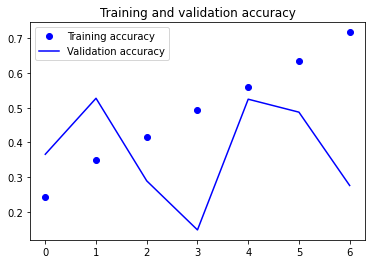

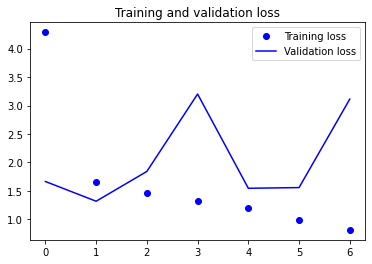

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
evaluate_model(model, test_images)

48/48 [==============================] - 6s 118ms/step - loss: 1.3154 - accuracy: 0.5275
Loss on test set: 1.315362572669983
Accuracy on test set: 0.527465283870697
                precision    recall  f1-score   support

       Actinic     0.1639    0.4000    0.2326        50
           BCC     0.2632    0.3125    0.2857        80
Dermatofibroma     0.1250    0.2222    0.1600        18
     Keratosis     0.2292    0.0663    0.1028       166
      Melanoma     0.2081    0.3690    0.2661       168
          Nevu     0.8119    0.6514    0.7229      1007
      Vascular     0.1759    0.8636    0.2923        22

      accuracy                         0.5275      1511
     macro avg     0.2824    0.4122    0.2946      1511
  weighted avg     0.6128    0.5275    0.5516      1511



48/48 [==============================] - 5s 97ms/step


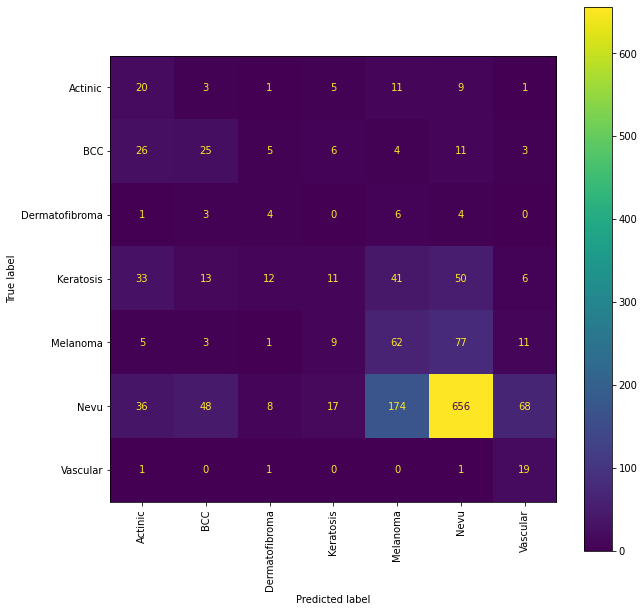

In [ ]:
plot_confusionmatrix(model, test_images)

## Convolution Layers = 4, Dense Layer = 1, Dropout Layer = 0

In [ ]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)
x = layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)
x = layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(3,3))(x)
x = layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(4,4))(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu', name='hidden_classifier') (x)
outputs = layers.Dense(7, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model = compile_model(model, loss="sparse_categorical_crossentropy", optimizer = 'rmsprop', learning_rate=0.001)
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_4 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 112, 112, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 56, 56, 64)       0         
 g2D)                                                      

In [ ]:
model, history = run_model(model, "Dense1_C4_Drop0_B", training_images, val_images, EPOCHS, patience=5, monitor='val_loss')

Epoch 1/50
66/66 [==============================] - ETA: 0s - loss: 1.9412 - accuracy: 0.1786
Epoch 1: val_loss improved from inf to 3.87770, saving model to /content/models/Dense1_C4_Drop0_B.h5
66/66 [==============================] - 377s 5s/step - loss: 1.9412 - accuracy: 0.1786 - val_loss: 3.8777 - val_accuracy: 0.0433
Epoch 2/50
65/66 [============================>.] - ETA: 0s - loss: 1.7350 - accuracy: 0.3063
Epoch 2: val_loss improved from 3.87770 to 1.57447, saving model to /content/models/Dense1_C4_Drop0_B.h5
66/66 [==============================] - 12s 177ms/step - loss: 1.7317 - accuracy: 0.3067 - val_loss: 1.5745 - val_accuracy: 0.3387
Epoch 3/50
65/66 [============================>.] - ETA: 0s - loss: 1.5427 - accuracy: 0.3721
Epoch 3: val_loss improved from 1.57447 to 1.43101, saving model to /content/models/Dense1_C4_Drop0_B.h5
66/66 [==============================] - 12s 173ms/step - loss: 1.5428 - accuracy: 0.3733 - val_loss: 1.4310 - val_accuracy: 0.2487
Epoch 4/50
65

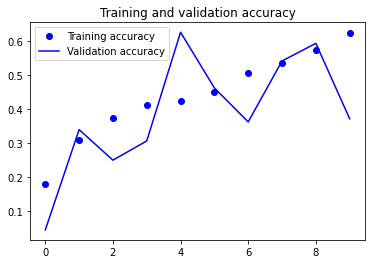

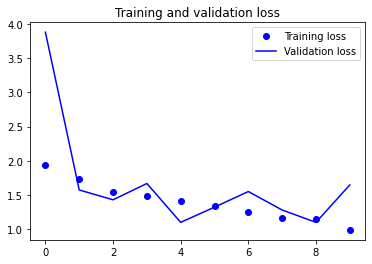

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
evaluate_model(model, test_images)

48/48 [==============================] - 162s 3s/step - loss: 1.1055 - accuracy: 0.6128
Loss on test set: 1.1055128574371338
Accuracy on test set: 0.6128391623497009
                precision    recall  f1-score   support

       Actinic     0.3077    0.1600    0.2105        50
           BCC     0.3636    0.0500    0.0879        80
Dermatofibroma     0.0474    0.5556    0.0873        18
     Keratosis     0.2642    0.1687    0.2059       166
      Melanoma     0.4167    0.0893    0.1471       168
          Nevu     0.8094    0.8352    0.8221      1007
      Vascular     0.2439    0.9091    0.3846        22

      accuracy                         0.6128      1511
     macro avg     0.3504    0.3954    0.2779      1511
  weighted avg     0.6483    0.6128    0.6051      1511



48/48 [==============================] - 5s 94ms/step


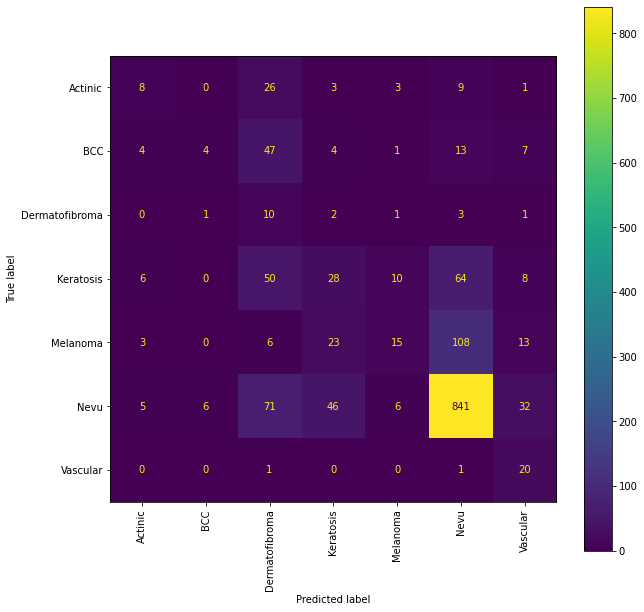

In [ ]:
plot_confusionmatrix(model, test_images)

## Convolution Layers = 5, Dense Layer = 1, Dropout Layers = 2

In [ ]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=3)(x)
x = layers.Conv2D(filters=512, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=3)(x)
x = layers.Flatten()(x)
x = layers.Dropout(DROPOUT)(x)
x = layers.Dense(512, activation='relu', name='hidden_classifier')(x)
x = layers.Dropout(DROPOUT)(x)
outputs = layers.Dense(7, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model = compile_model(model, loss="sparse_categorical_crossentropy")
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_5 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_20 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 112, 112, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 56, 56, 64)       0         
 g2D)                                                      

In [ ]:
model, history = run_model(model, "Dense1_C5_Drop2_B", training_images, val_images, EPOCHS, patience=5, monitor='val_loss')

Epoch 1/50
66/66 [==============================] - ETA: 0s - loss: 1.9405 - accuracy: 0.1624
Epoch 1: val_loss improved from inf to 1.94298, saving model to /content/models/Dense1_C5_Drop2_B.h5
66/66 [==============================] - 13s 177ms/step - loss: 1.9405 - accuracy: 0.1624 - val_loss: 1.9430 - val_accuracy: 0.0560
Epoch 2/50
65/66 [============================>.] - ETA: 0s - loss: 1.8266 - accuracy: 0.2288
Epoch 2: val_loss improved from 1.94298 to 1.76288, saving model to /content/models/Dense1_C5_Drop2_B.h5
66/66 [==============================] - 12s 177ms/step - loss: 1.8271 - accuracy: 0.2295 - val_loss: 1.7629 - val_accuracy: 0.2327
Epoch 3/50
65/66 [============================>.] - ETA: 0s - loss: 1.7572 - accuracy: 0.2519
Epoch 3: val_loss improved from 1.76288 to 1.41458, saving model to /content/models/Dense1_C5_Drop2_B.h5
66/66 [==============================] - 12s 174ms/step - loss: 1.7591 - accuracy: 0.2505 - val_loss: 1.4146 - val_accuracy: 0.5107
Epoch 4/50


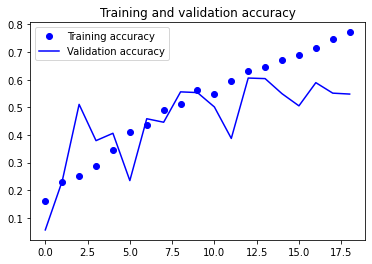

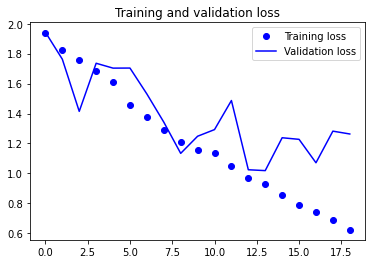

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
evaluate_model(model, test_images)

48/48 [==============================] - 5s 94ms/step - loss: 1.0225 - accuracy: 0.6221
Loss on test set: 1.02254056930542
Accuracy on test set: 0.6221045851707458
                precision    recall  f1-score   support

       Actinic     0.2203    0.2600    0.2385        50
           BCC     0.3690    0.3875    0.3780        80
Dermatofibroma     0.1321    0.3889    0.1972        18
     Keratosis     0.3318    0.4217    0.3714       166
      Melanoma     0.3373    0.5119    0.4066       168
          Nevu     0.8912    0.7080    0.7892      1007
      Vascular     0.4082    0.9091    0.5634        22

      accuracy                         0.6221      1511
     macro avg     0.3843    0.5124    0.4206      1511
  weighted avg     0.7023    0.6221    0.6504      1511



48/48 [==============================] - 5s 94ms/step


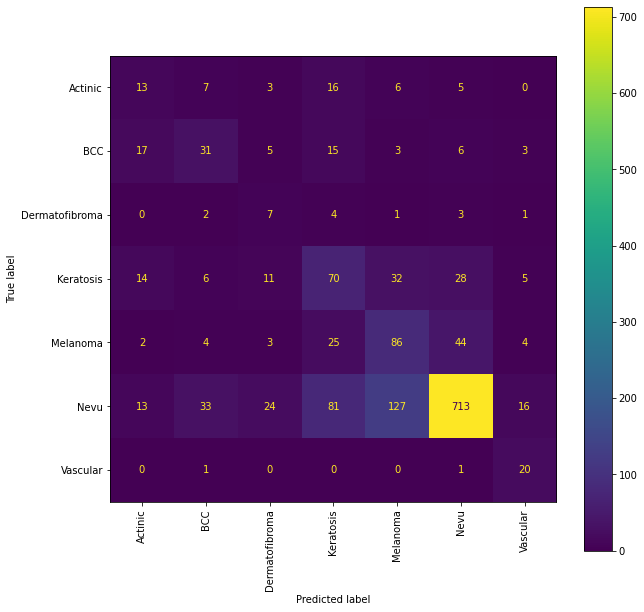

In [ ]:
plot_confusionmatrix(model, test_images)

## Convolution Layers = 4, Dense Layer = 1, Multiple Dropout Layers

In [ ]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)
x = layers.Dropout(DROPOUT)(x)
x = layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)
x = layers.Dropout(DROPOUT)(x)
x = layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(3,3))(x)
x = layers.Dropout(DROPOUT)(x)
x = layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(4,4))(x)
x = layers.Flatten()(x)
x = layers.Dropout(DROPOUT)(x)
x = layers.Dense(256, activation='relu', name='hidden_classifier') (x)
outputs = layers.Dense(7, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model = compile_model(model, loss="sparse_categorical_crossentropy", optimizer = 'rmsprop', learning_rate=0.0005)
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_6 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_25 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 112, 112, 32)     0         
 g2D)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 112, 112, 32)      0         
                                                                 
 conv2d_26 (Conv2D)          (None, 112, 112, 64)      18496     
                                                           

In [ ]:
model, history = run_model(model, "Dense1_C4_DropMulti_B", training_images, val_images, EPOCHS, patience=5, monitor='val_loss')

Epoch 1/50
65/66 [============================>.] - ETA: 0s - loss: 2.0298 - accuracy: 0.1428
Epoch 1: val_loss improved from inf to 1.94053, saving model to /content/models/Dense1_C4_DropMulti_B.h5
66/66 [==============================] - 13s 173ms/step - loss: 2.0294 - accuracy: 0.1433 - val_loss: 1.9405 - val_accuracy: 0.0140
Epoch 2/50
66/66 [==============================] - ETA: 0s - loss: 1.9207 - accuracy: 0.1833
Epoch 2: val_loss improved from 1.94053 to 1.73310, saving model to /content/models/Dense1_C4_DropMulti_B.h5
66/66 [==============================] - 12s 174ms/step - loss: 1.9207 - accuracy: 0.1833 - val_loss: 1.7331 - val_accuracy: 0.5827
Epoch 3/50
66/66 [==============================] - ETA: 0s - loss: 1.6825 - accuracy: 0.3043
Epoch 3: val_loss improved from 1.73310 to 1.58797, saving model to /content/models/Dense1_C4_DropMulti_B.h5
66/66 [==============================] - 12s 171ms/step - loss: 1.6825 - accuracy: 0.3043 - val_loss: 1.5880 - val_accuracy: 0.4733

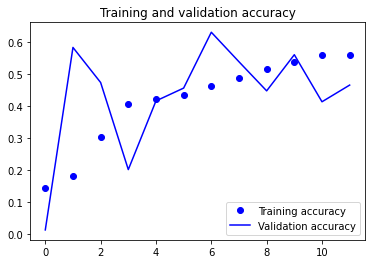

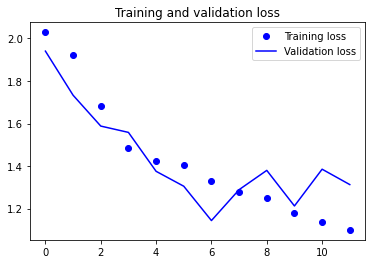

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
evaluate_model(model, test_images)

48/48 [==============================] - 5s 93ms/step - loss: 1.1411 - accuracy: 0.6334
Loss on test set: 1.1411441564559937
Accuracy on test set: 0.6333553791046143
                precision    recall  f1-score   support

       Actinic     0.2727    0.0600    0.0984        50
           BCC     0.3415    0.1750    0.2314        80
Dermatofibroma     0.0769    0.6111    0.1366        18
     Keratosis     0.3810    0.1928    0.2560       166
      Melanoma     0.2970    0.2917    0.2943       168
          Nevu     0.8150    0.8222    0.8186      1007
      Vascular     0.3922    0.9091    0.5479        22

      accuracy                         0.6334      1511
     macro avg     0.3680    0.4374    0.3405      1511
  weighted avg     0.6517    0.6334    0.6315      1511



48/48 [==============================] - 4s 92ms/step


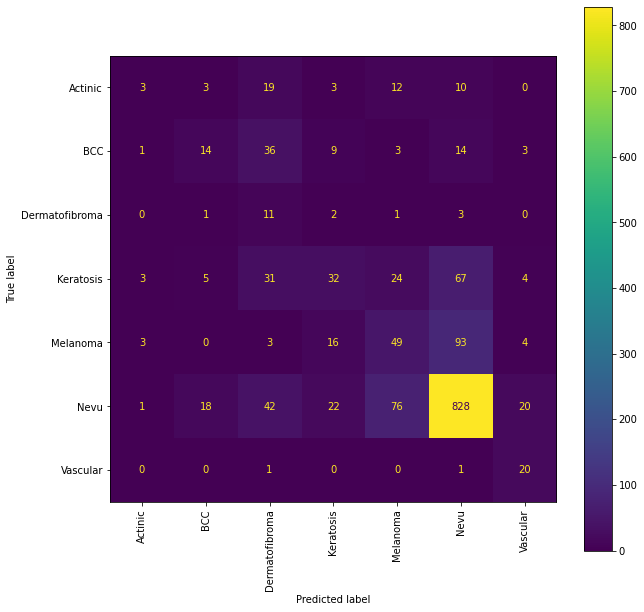

In [ ]:
plot_confusionmatrix(model, test_images)

# Approach: Class Weights

Compute the Class Weights.

In [ ]:
artists = pd.read_csv('/content/gdrive/MyDrive/SkinCancer/HAM10000_metadata.csv')


In [ ]:
artists['dx'].value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

In [ ]:
def create_class_weight(labels_dict,mu=0.7):
    total = np.sum(list(labels_dict.values()))
    keys = labels_dict.keys()
    class_weight = dict()
    
    for key in keys:
        score = math.log(mu*total/float(labels_dict[key]))
        class_weight[key] = score if score > 0.5 else 0.5
    
    return class_weight


labels_dict = {0:327, 1:514, 2:115, 3:1099, 4:1113, 5:6705, 6:142}

class_weight = create_class_weight(labels_dict)

In [ ]:
class_weight

{0: 3.065204133263933,
 1: 2.6129410387060212,
 2: 4.110232175797936,
 3: 1.853008349757565,
 4: 1.8403499528856415,
 5: 0.5,
 6: 3.8993372465599254}

##Dataset Loading

In [ ]:
TRAIN_DIR = '/content/gdrive/MyDrive/SkinCancer/OriginalDataset/train'
VAL_DIR = '/content/gdrive/MyDrive/SkinCancer/OriginalDataset/val'
TEST_DIR = '/content/gdrive/MyDrive/SkinCancer/OriginalDataset/test'

Note that since 450x600 is too large, It is used the interpolation tool in Keras to resize the images in 224x224, also to fit the input of most pretrained networks.

In [ ]:
training_images = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    labels='inferred',
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    image_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
    interpolation='bilinear',
    shuffle=True,
    seed=RANDOM_SEED
)

val_images = tf.keras.preprocessing.image_dataset_from_directory(
    VAL_DIR,
    labels='inferred',
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    image_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
    interpolation='bilinear',
    shuffle=True,
    seed=RANDOM_SEED
)

test_images = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR,
    labels='inferred',
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    image_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
    interpolation='bilinear',
    shuffle=False,
    seed=RANDOM_SEED
)

Found 7014 files belonging to 7 classes.
Found 1500 files belonging to 7 classes.
Found 1511 files belonging to 7 classes.


## Convolutional Layers = 3, Dense Layer = 1, Dropout Layer = 1

In [ ]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)
x = layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)
x = layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(DROPOUT)(x)
x = layers.Dense(256, activation='relu', name='hidden_classifier') (x)
outputs = layers.Dense(7, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model = compile_model(model, loss="sparse_categorical_crossentropy", optimizer = 'rmsprop', learning_rate=0.001)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                         

In [ ]:
model, history = run_model(model, "Dense1_C3_Drop1_CW", training_images, val_images, EPOCHS, patience=5, monitor='val_loss',class_weight=class_weight)

Epoch 1/50
220/220 [==============================] - ETA: 0s - loss: 2.1653 - accuracy: 0.5557
Epoch 1: val_loss improved from inf to 1.09242, saving model to /content/models/Dense1_C3_Drop1_CW.h5
220/220 [==============================] - 970s 4s/step - loss: 2.1653 - accuracy: 0.5557 - val_loss: 1.0924 - val_accuracy: 0.6187
Epoch 2/50
220/220 [==============================] - ETA: 0s - loss: 1.5252 - accuracy: 0.5918
Epoch 2: val_loss improved from 1.09242 to 1.09071, saving model to /content/models/Dense1_C3_Drop1_CW.h5
220/220 [==============================] - 32s 140ms/step - loss: 1.5252 - accuracy: 0.5918 - val_loss: 1.0907 - val_accuracy: 0.6153
Epoch 3/50
220/220 [==============================] - ETA: 0s - loss: 1.3877 - accuracy: 0.6245
Epoch 3: val_loss improved from 1.09071 to 0.97729, saving model to /content/models/Dense1_C3_Drop1_CW.h5
220/220 [==============================] - 35s 155ms/step - loss: 1.3877 - accuracy: 0.6245 - val_loss: 0.9773 - val_accuracy: 0.623

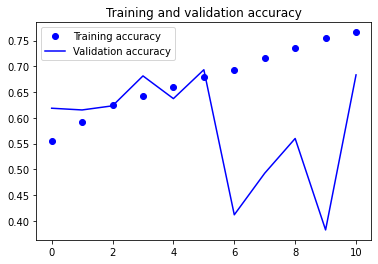

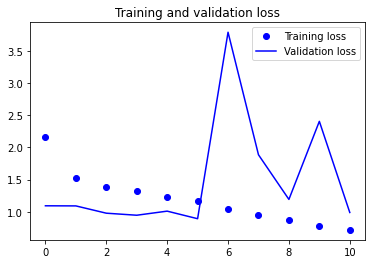

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
evaluate_model(model, test_images)

48/48 [==============================] - 168s 3s/step - loss: 0.9088 - accuracy: 0.6982
Loss on test set: 0.9088456034660339
Accuracy on test set: 0.6982131004333496
                precision    recall  f1-score   support

       Actinic     0.4375    0.1400    0.2121        50
           BCC     0.5172    0.1875    0.2752        80
Dermatofibroma     0.1562    0.2778    0.2000        18
     Keratosis     0.3480    0.4277    0.3838       166
      Melanoma     0.3951    0.3810    0.3879       168
          Nevu     0.8365    0.8739    0.8548      1007
      Vascular     0.8125    0.5909    0.6842        22

      accuracy                         0.6982      1511
     macro avg     0.5004    0.4112    0.4283      1511
  weighted avg     0.6952    0.6982    0.6889      1511



48/48 [==============================] - 4s 93ms/step


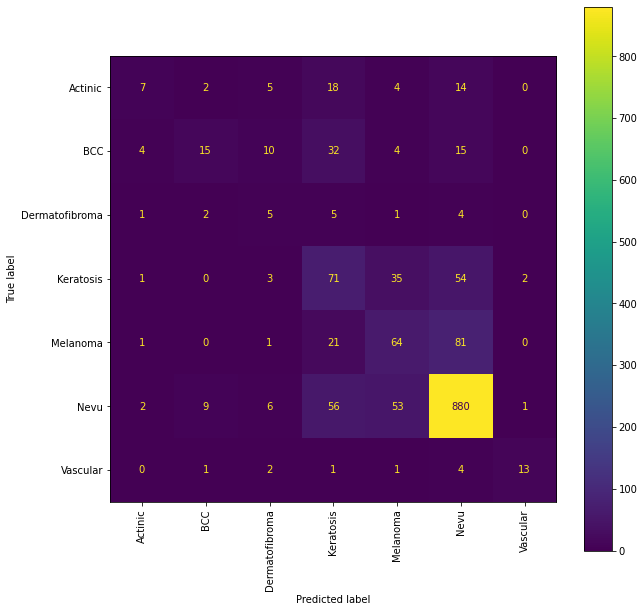

In [ ]:
plot_confusionmatrix(model, test_images)

## Convolution Layers = 4, Dense Layer = 1, Dropout Layer = 0

In [ ]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)
x = layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)
x = layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(3,3))(x)
x = layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(4,4))(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu', name='hidden_classifier') (x)
outputs = layers.Dense(7, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model = compile_model(model, loss="sparse_categorical_crossentropy", optimizer = 'rmsprop', learning_rate=0.001)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                       

In [ ]:
model, history = run_model(model, "Dense1_C4_Drop0_CW", training_images, val_images, EPOCHS, patience=5, monitor='val_loss')

Epoch 1/50
220/220 [==============================] - ETA: 0s - loss: 1.0945 - accuracy: 0.6620
Epoch 1: val_loss improved from inf to 1.13588, saving model to /content/models/Dense1_C4_Drop0_CW.h5
220/220 [==============================] - 30s 126ms/step - loss: 1.0945 - accuracy: 0.6620 - val_loss: 1.1359 - val_accuracy: 0.6727
Epoch 2/50
219/220 [============================>.] - ETA: 0s - loss: 0.9220 - accuracy: 0.6762
Epoch 2: val_loss improved from 1.13588 to 0.86299, saving model to /content/models/Dense1_C4_Drop0_CW.h5
220/220 [==============================] - 31s 136ms/step - loss: 0.9220 - accuracy: 0.6762 - val_loss: 0.8630 - val_accuracy: 0.6940
Epoch 3/50
219/220 [============================>.] - ETA: 0s - loss: 0.8365 - accuracy: 0.6962
Epoch 3: val_loss improved from 0.86299 to 0.82040, saving model to /content/models/Dense1_C4_Drop0_CW.h5
220/220 [==============================] - 29s 126ms/step - loss: 0.8361 - accuracy: 0.6965 - val_loss: 0.8204 - val_accuracy: 0.7

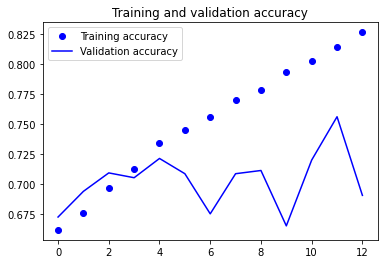

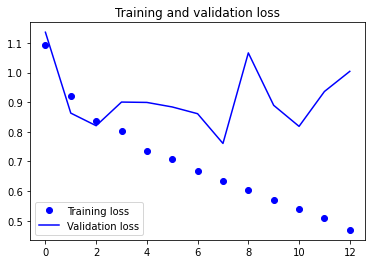

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
evaluate_model(model, test_images)

48/48 [==============================] - 5s 94ms/step - loss: 0.7634 - accuracy: 0.7240
Loss on test set: 0.7634065747261047
Accuracy on test set: 0.7240238189697266
                precision    recall  f1-score   support

       Actinic     0.2347    0.4600    0.3108        50
           BCC     0.4884    0.2625    0.3415        80
Dermatofibroma     0.4286    0.1667    0.2400        18
     Keratosis     0.3968    0.6024    0.4785       166
      Melanoma     0.5234    0.3988    0.4527       168
          Nevu     0.8964    0.8590    0.8773      1007
      Vascular     0.8333    0.6818    0.7500        22

      accuracy                         0.7240      1511
     macro avg     0.5431    0.4902    0.4930      1511
  weighted avg     0.7500    0.7240    0.7297      1511



48/48 [==============================] - 5s 94ms/step


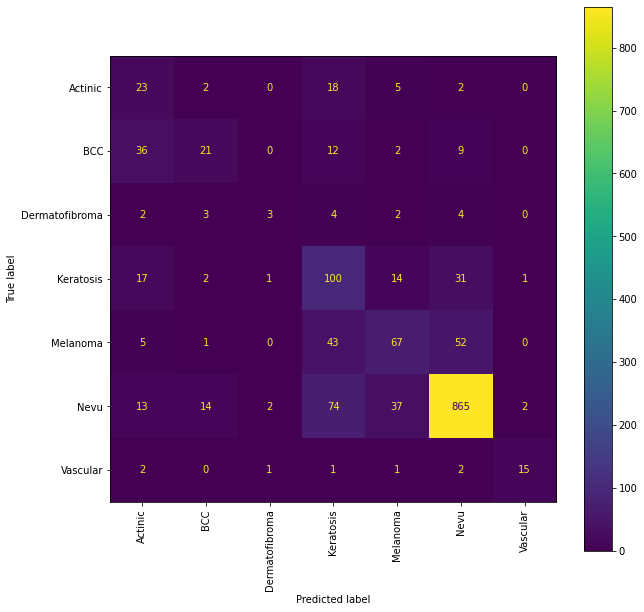

In [ ]:
plot_confusionmatrix(model, test_images)

## Convolution Layers = 5, Dense Layer = 1, Dropout Layers = 2

In [ ]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=3)(x)
x = layers.Conv2D(filters=512, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=3)(x)
x = layers.Flatten()(x)
x = layers.Dropout(DROPOUT)(x)
x = layers.Dense(512, activation='relu', name='hidden_classifier')(x)
x = layers.Dropout(DROPOUT)(x)
outputs = layers.Dense(7, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model = compile_model(model, loss="sparse_categorical_crossentropy")
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                       

In [ ]:
model, history = run_model(model, "Dense1_C5_Drop2_CW", training_images, val_images, EPOCHS, patience=5, monitor='val_loss')

Epoch 1/50
220/220 [==============================] - ETA: 0s - loss: 1.1583 - accuracy: 0.6510
Epoch 1: val_loss improved from inf to 1.00266, saving model to /content/models/Dense1_C5_Drop2_CW.h5
220/220 [==============================] - 30s 127ms/step - loss: 1.1583 - accuracy: 0.6510 - val_loss: 1.0027 - val_accuracy: 0.6700
Epoch 2/50
219/220 [============================>.] - ETA: 0s - loss: 0.9740 - accuracy: 0.6718
Epoch 2: val_loss improved from 1.00266 to 0.93167, saving model to /content/models/Dense1_C5_Drop2_CW.h5
220/220 [==============================] - 28s 124ms/step - loss: 0.9738 - accuracy: 0.6718 - val_loss: 0.9317 - val_accuracy: 0.6847
Epoch 3/50
219/220 [============================>.] - ETA: 0s - loss: 0.8963 - accuracy: 0.6865
Epoch 3: val_loss improved from 0.93167 to 0.86914, saving model to /content/models/Dense1_C5_Drop2_CW.h5
220/220 [==============================] - 28s 125ms/step - loss: 0.8968 - accuracy: 0.6862 - val_loss: 0.8691 - val_accuracy: 0.6

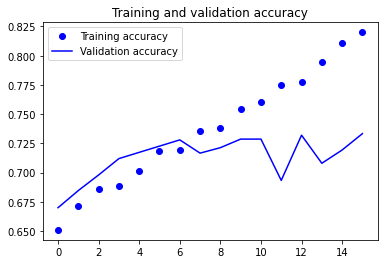

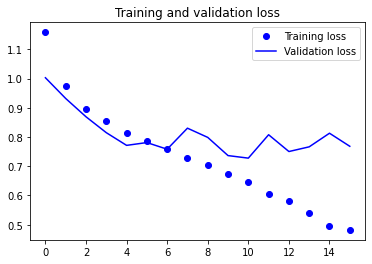

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
evaluate_model(model, test_images)

48/48 [==============================] - 7s 144ms/step - loss: 0.7231 - accuracy: 0.7300
Loss on test set: 0.7230563163757324
Accuracy on test set: 0.7299801707267761
                precision    recall  f1-score   support

       Actinic     0.2045    0.1800    0.1915        50
           BCC     0.5429    0.4750    0.5067        80
Dermatofibroma     0.0000    0.0000    0.0000        18
     Keratosis     0.3551    0.2289    0.2784       166
      Melanoma     0.4964    0.4048    0.4459       168
          Nevu     0.8258    0.9275    0.8737      1007
      Vascular     0.7273    0.7273    0.7273        22

      accuracy                         0.7300      1511
     macro avg     0.4503    0.4205    0.4319      1511
  weighted avg     0.6907    0.7300    0.7062      1511



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


48/48 [==============================] - 5s 95ms/step


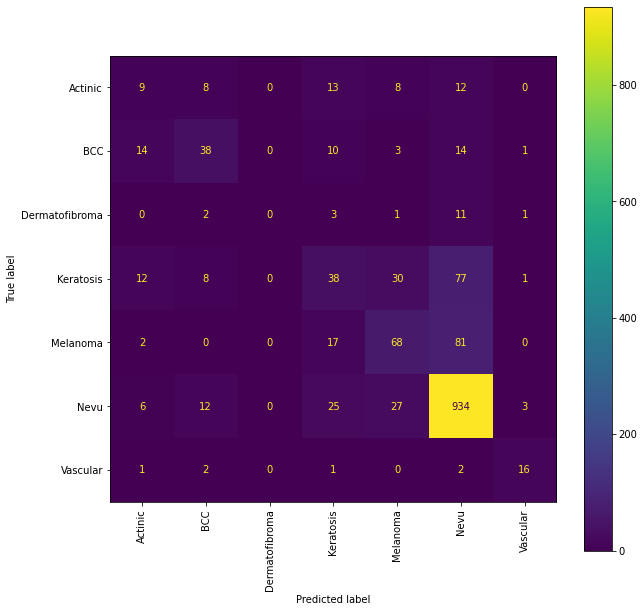

In [ ]:
plot_confusionmatrix(model, test_images)

## Convolution Layers = 4, Dense Layer = 1, Multiple Dropout Layers

In [ ]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)
x = layers.Dropout(DROPOUT)(x)
x = layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)
x = layers.Dropout(DROPOUT)(x)
x = layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(3,3))(x)
x = layers.Dropout(DROPOUT)(x)
x = layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(4,4))(x)
x = layers.Flatten()(x)
x = layers.Dropout(DROPOUT)(x)
x = layers.Dense(256, activation='relu', name='hidden_classifier') (x)
outputs = layers.Dense(7, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model = compile_model(model, loss="sparse_categorical_crossentropy", optimizer = 'rmsprop')
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_3 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 112, 112, 32)     0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 112, 112, 32)      0         
                                                                 
 conv2d_13 (Conv2D)          (None, 112, 112, 64)      18496     
                                                           

In [ ]:
model, history = run_model(model, "Dense1_C4_DropMulti_CW", training_images, val_images, EPOCHS, patience=5, monitor='val_loss')

Epoch 1/50
219/220 [============================>.] - ETA: 0s - loss: 1.1666 - accuracy: 0.6660
Epoch 1: val_loss improved from inf to 1.32199, saving model to /content/models/Dense1_C4_DropMulti_CW.h5
220/220 [==============================] - 29s 122ms/step - loss: 1.1667 - accuracy: 0.6658 - val_loss: 1.3220 - val_accuracy: 0.5453
Epoch 2/50
219/220 [============================>.] - ETA: 0s - loss: 0.9509 - accuracy: 0.6709
Epoch 2: val_loss improved from 1.32199 to 0.97743, saving model to /content/models/Dense1_C4_DropMulti_CW.h5
220/220 [==============================] - 27s 121ms/step - loss: 0.9512 - accuracy: 0.6711 - val_loss: 0.9774 - val_accuracy: 0.6787
Epoch 3/50
219/220 [============================>.] - ETA: 0s - loss: 0.8861 - accuracy: 0.6849
Epoch 3: val_loss did not improve from 0.97743
220/220 [==============================] - 28s 124ms/step - loss: 0.8855 - accuracy: 0.6852 - val_loss: 1.0960 - val_accuracy: 0.6813
Epoch 4/50
219/220 [===========================

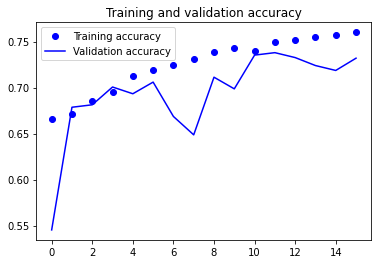

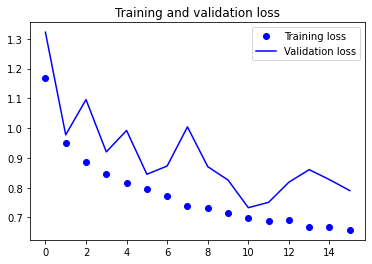

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
evaluate_model(model, test_images)

48/48 [==============================] - 5s 90ms/step - loss: 0.7167 - accuracy: 0.7300
Loss on test set: 0.7166834473609924
Accuracy on test set: 0.7299801707267761
                precision    recall  f1-score   support

       Actinic     0.2105    0.1600    0.1818        50
           BCC     0.5405    0.2500    0.3419        80
Dermatofibroma     0.4286    0.1667    0.2400        18
     Keratosis     0.3812    0.3675    0.3742       166
      Melanoma     0.5000    0.4226    0.4581       168
          Nevu     0.8329    0.9206    0.8745      1007
      Vascular     0.9286    0.5909    0.7222        22

      accuracy                         0.7300      1511
     macro avg     0.5460    0.4112    0.4561      1511
  weighted avg     0.7068    0.7300    0.7124      1511



48/48 [==============================] - 5s 93ms/step


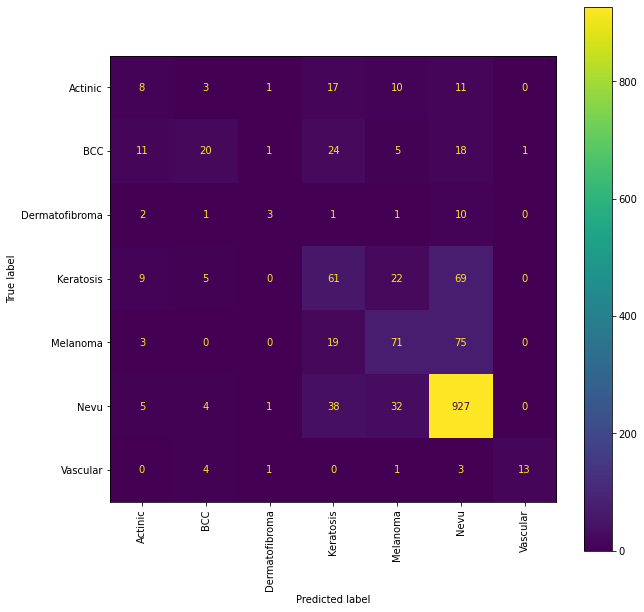

In [ ]:
plot_confusionmatrix(model, test_images)